# 03 - Modelisation Energie (NonResidential)

Meme cadre methodologique que CO2 pour garder une comparaison claire et reproductible.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

sns.set_style('whitegrid')

from sklearn.cluster import KMeans


In [11]:
# Chargement + filtres
df = pd.read_csv('../2016_Building_Energy_Benchmarking.csv')
df = df[df['BuildingType'] == 'NonResidential'].copy()
df = df[df['ComplianceStatus'] == 'Compliant'].copy()
if 'Outlier' in df.columns:
    df = df[df['Outlier'].fillna('').str.lower() != 'high outlier']

# Feature engineering 
df['BuildingAge'] = (2016 - df['YearBuilt']).clip(lower=0)
df['ParkingRatio'] = np.where(df['PropertyGFATotal'] > 0, df['PropertyGFAParking'] / df['PropertyGFATotal'], 0)
df['MainUseRatio'] = np.where(df['PropertyGFATotal'] > 0, df['LargestPropertyUseTypeGFA'] / df['PropertyGFATotal'], 0)

# Geo-cluster a partir de la position
geo_tmp = df.dropna(subset=['Latitude', 'Longitude']).copy()
geo_model = KMeans(n_clusters=5, random_state=42, n_init=10)
geo_tmp['GeoCluster'] = geo_model.fit_predict(geo_tmp[['Latitude', 'Longitude']]).astype(str)
df = df.merge(geo_tmp[['OSEBuildingID', 'GeoCluster']], on='OSEBuildingID', how='left')
df['GeoCluster'] = df['GeoCluster'].fillna('NA')

num_features = [
    'YearBuilt', 'BuildingAge', 'NumberofBuildings', 'NumberofFloors',
    'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
    'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA', 'ParkingRatio', 'MainUseRatio',
    'ENERGYSTARScore'
]
cat_features = ['PrimaryPropertyType', 'Neighborhood', 'GeoCluster']

features = [c for c in (num_features + cat_features) if c in df.columns]
df_model = df[features + ['SiteEnergyUse(kBtu)']].dropna(subset=['SiteEnergyUse(kBtu)']).copy()

X = df_model[features]
y = df_model['SiteEnergyUse(kBtu)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_used = [c for c in num_features if c in X_train.columns]
cat_used = [c for c in cat_features if c in X_train.columns]

# Variables numeriques asymetriques (calculees sur train pour eviter la fuite)
sk_train = X_train[num_used].skew(numeric_only=True).abs()
num_log = [c for c in num_used if sk_train.get(c, 0) > 1 and X_train[c].min() >= 0]
num_regular = [c for c in num_used if c not in num_log]

print('Shape modele:', X.shape)
print('Variables log1p:', num_log)
print('Variables numeriques standard:', num_regular)
print('Variables categoriques:', cat_used)


Shape modele: (1432, 16)
Variables log1p: ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ParkingRatio', 'MainUseRatio']
Variables numeriques standard: ['YearBuilt', 'BuildingAge', 'ENERGYSTARScore']
Variables categoriques: ['PrimaryPropertyType', 'Neighborhood', 'GeoCluster']


In [12]:
# Preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ('num_log', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('log', FunctionTransformer(np.log1p, validate=False))
        ]), num_log),
        ('num_regular', Pipeline([
            ('imputer', SimpleImputer(strategy='median'))
        ]), num_regular),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_used)
    ],
    remainder='drop'
)

models = {
    'Ridge': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=250, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

rows = []
for name, reg in models.items():
    pipe = Pipeline([
        ('prep', preprocess),
        ('reg', TransformedTargetRegressor(
            regressor=reg,
            func=np.log1p,
            inverse_func=np.expm1
        ))
    ])
    cv = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)
    rows.append({
        'model': name,
        'cv_rmse': -cv['test_rmse'].mean(),
        'cv_mae': -cv['test_mae'].mean(),
        'cv_r2': cv['test_r2'].mean()
    })

cv_results = pd.DataFrame(rows).sort_values('cv_rmse').reset_index(drop=True)
cv_results


,model,cv_rmse,cv_mae,cv_r2
0,GradientBoosting,1.028795e+07,3.192223e+06,0.693279
1,RandomForest,1.160138e+07,3.471920e+06,0.634612
2,Ridge,1.174285e+07,3.377753e+06,0.577102


In [13]:
# Choix final = meilleur RMSE CV + evaluation train/test
best_name = cv_results.loc[0, 'model']
best_reg = models[best_name]

final_model = Pipeline([
    ('prep', preprocess),
    ('reg', TransformedTargetRegressor(
        regressor=best_reg,
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

final_model.fit(X_train, y_train)
pred_train = final_model.predict(X_train)
pred_test = final_model.predict(X_test)

def eval_metrics(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

train_metrics = eval_metrics(y_train, pred_train)
test_metrics = eval_metrics(y_test, pred_test)

metrics_df = pd.DataFrame([
    {'Set': 'Train', **train_metrics},
    {'Set': 'Test', **test_metrics}
])

print('Modele retenu:', best_name)
metrics_df


Modele retenu: GradientBoosting


,Set,RMSE,MAE,R2
0,Train,8.526592e+06,2.379468e+06,0.826155
1,Test,5.582902e+06,2.347935e+06,0.817747


In [14]:
# Test de pertinence ENERGY STAR Score
features_wo_star = [c for c in features if c != 'ENERGYSTARScore']
X2 = df_model[features_wo_star]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42)

num2 = [c for c in num_features if c in X2_train.columns]
cat2 = [c for c in cat_features if c in X2_train.columns]
sk2 = X2_train[num2].skew(numeric_only=True).abs()
num2_log = [c for c in num2 if sk2.get(c, 0) > 1 and X2_train[c].min() >= 0]
num2_reg = [c for c in num2 if c not in num2_log]

prep2 = ColumnTransformer([
    ('num_log', Pipeline([('imputer', SimpleImputer(strategy='median')), ('log', FunctionTransformer(np.log1p, validate=False))]), num2_log),
    ('num_regular', Pipeline([('imputer', SimpleImputer(strategy='median'))]), num2_reg),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat2)
], remainder='drop')

model_with_star = final_model
model_wo_star = Pipeline([
    ('prep', prep2),
    ('reg', TransformedTargetRegressor(regressor=best_reg, func=np.log1p, inverse_func=np.expm1))
])

model_with_star.fit(X_train, y_train)
model_wo_star.fit(X2_train, y2_train)

pred_with = model_with_star.predict(X_test)
pred_wo = model_wo_star.predict(X2_test)

compare = pd.DataFrame({
    'version': ['avec_ENERGYSTAR', 'sans_ENERGYSTAR'],
    'RMSE': [np.sqrt(mean_squared_error(y_test, pred_with)), np.sqrt(mean_squared_error(y2_test, pred_wo))],
    'MAE': [mean_absolute_error(y_test, pred_with), mean_absolute_error(y2_test, pred_wo)],
    'R2': [r2_score(y_test, pred_with), r2_score(y2_test, pred_wo)]
})
compare

,version,RMSE,MAE,R2
0,avec_ENERGYSTAR,5.582902e+06,2.347935e+06,0.817747
1,sans_ENERGYSTAR,5.871621e+06,2.735025e+06,0.798410


In [15]:
# Diagnostic fuite de donnees + overfitting
forbidden_cols = {
    'TotalGHGEmissions', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
    'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)',
    'NaturalGas(therms)', 'NaturalGas(kBtu)',
    'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
    'GHGEmissionsIntensity'
}

used_forbidden = sorted(set(features).intersection(forbidden_cols))

# Verifier qu'il n'y a pas d'observations identiques entre train/test
train_hash = set(pd.util.hash_pandas_object(X_train.fillna('__NA__'), index=False))
test_hash = set(pd.util.hash_pandas_object(X_test.fillna('__NA__'), index=False))
shared_rows = len(train_hash.intersection(test_hash))

rmse_gap_ratio = test_metrics['RMSE'] / max(train_metrics['RMSE'], 1e-9)
r2_gap = train_metrics['R2'] - test_metrics['R2']

print('Colonnes interdites utilisees:', used_forbidden if used_forbidden else 'Aucune')
print('Lignes potentiellement dupliquees entre train/test:', shared_rows)
print('RMSE ratio (test/train):', round(rmse_gap_ratio, 3))
print('R2 gap (train-test):', round(r2_gap, 3))

if used_forbidden:
    print('ALERTE fuite: une ou plusieurs colonnes cibles/proxy sont utilisees.')
elif shared_rows > 0:
    print('ALERTE fuite potentielle: observations quasi identiques entre train/test.')
else:
    print('Audit fuite: aucun signal fort de fuite detecte.')

if (rmse_gap_ratio > 1.3) or (r2_gap > 0.15):
    print('Diagnostic overfitting: risque present (ecart train/test notable).')
else:
    print('Diagnostic overfitting: risque limite (ecart train/test acceptable).')


Colonnes interdites utilisees: Aucune
Lignes potentiellement dupliquees entre train/test: 0
RMSE ratio (test/train): 0.655
R2 gap (train-test): 0.008
Audit fuite: aucun signal fort de fuite detecte.
Diagnostic overfitting: risque limite (ecart train/test acceptable).


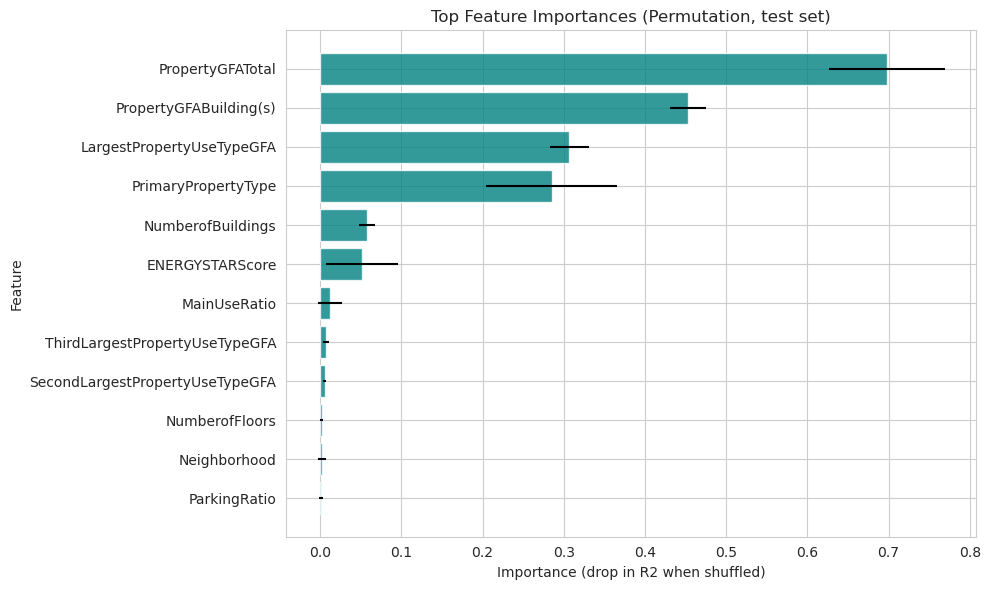

,feature,importance_mean,importance_std
4,PropertyGFATotal,0.698205,0.071299
6,PropertyGFABuilding(s),0.453006,0.022478
7,LargestPropertyUseTypeGFA,0.306642,0.024139
13,PrimaryPropertyType,0.285196,0.080824
2,NumberofBuildings,0.057554,0.009975
12,ENERGYSTARScore,0.051309,0.044037
11,MainUseRatio,0.012100,0.015232
9,ThirdLargestPropertyUseTypeGFA,0.007198,0.003514
8,SecondLargestPropertyUseTypeGFA,0.005536,0.001755
3,NumberofFloors,0.001924,0.001826


In [16]:
# Feature importance (Permutation Importance)
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    final_model,
    X_test,
    y_test,
    scoring='r2',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

imp_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std
}).sort_values('importance_mean', ascending=False)

top_n = 12
top_imp = imp_df.head(top_n).iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(top_imp['feature'], top_imp['importance_mean'], xerr=top_imp['importance_std'], color='teal', alpha=0.8)
plt.title('Top Feature Importances (Permutation, test set)')
plt.xlabel('Importance (drop in R2 when shuffled)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

imp_df.head(15)


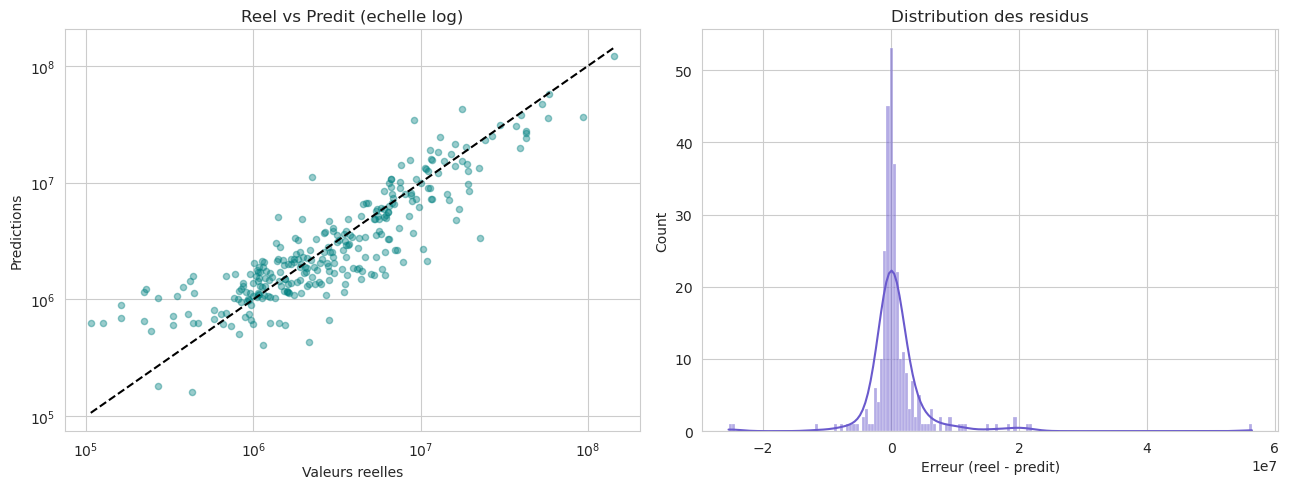

In [17]:
# Graphiques explicatifs du modele final
residuals = y_test - pred_test

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].scatter(y_test, pred_test, alpha=0.4, s=20, color='teal')
minv = min(y_test.min(), pred_test.min())
maxv = max(y_test.max(), pred_test.max())
axes[0].plot([minv, maxv], [minv, maxv], color='black', linestyle='--')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('Reel vs Predit (echelle log)')
axes[0].set_xlabel('Valeurs reelles')
axes[0].set_ylabel('Predictions')

sns.histplot(residuals, kde=True, ax=axes[1], color='slateblue')
axes[1].set_title('Distribution des residus')
axes[1].set_xlabel('Erreur (reel - predit)')

plt.tight_layout()
plt.show()

In [19]:
# Sauvegarde du modele retenu
model_dir = Path('models')
model_dir.mkdir(parents=True, exist_ok=True)
model_path = model_dir / 'energy_final_model.joblib'
joblib.dump(final_model, model_path)
print('Modele enregistre:', model_path)


Modele enregistre: models/energy_final_model.joblib


## Conclusion
- Pipeline identique a CO2 pour garder la coherence de projet.
- Gestion de skewness par `log1p` sur features numeriques asymetriques et sur la cible.
- Evaluation complete: CV + test + comparaison avec/sans `ENERGYSTARScore`.